## Importing libaries

In [1]:
# Tratamiento de datos
# -----------------------------------------------------------------------
import numpy as np
import pandas as pd

import math

# Visualizaciones
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt
import plotly_express as px


# Para el modelado de los datos
# -----------------------------------------------------------------------
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Preprocesado y modelado
# -----------------------------------------------------------------------
from sklearn.preprocessing import StandardScaler


# Sacar número de clusters y métricas
# -----------------------------------------------------------------------
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_score

# Modelos de clustering
# -----------------------------------------------------------------------
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.cluster import SpectralClustering

# Para visualizar los dendrogramas
# -----------------------------------------------------------------------
import scipy.cluster.hierarchy as sch
# Configuración warnings
# -----------------------------------------------------------------------
import warnings
warnings.filterwarnings('ignore')

# Path configuration for custom module imports  
# -----------------------------------------------------------------------  
import sys  
sys.path.append('../')  # Adds the parent directory to the path for custom module imports  

from src.support_eda import plot_relation_tv


## Data loading

In [2]:
df = pd.read_csv('../data/output/WrestlingWorldTournament_preprocessed.csv', index_col=0)

In [3]:
df.head()

,age,height,nationality,weight,hours_per_day,strength,agility,mental,federation,rank,gender_Female,gender_Male
0,0.657143,0.26,0.171171,0.293103,0.375,0.625,0.714286,0.571429,1.000000,0.082164,1.0,0.0
1,0.514286,0.66,0.981982,0.603448,0.000,0.750,0.285714,0.857143,0.000000,0.320641,0.0,1.0
2,0.314286,0.53,0.981982,0.482759,0.500,0.750,0.714286,0.571429,0.000000,0.304609,0.0,1.0
3,0.600000,0.71,0.981982,0.724138,0.375,0.625,0.428571,0.714286,1.000000,0.503006,0.0,1.0
4,0.314286,0.12,0.972973,0.120690,0.125,0.375,0.571429,0.571429,0.865385,0.719439,1.0,0.0


### Clustering using K-means

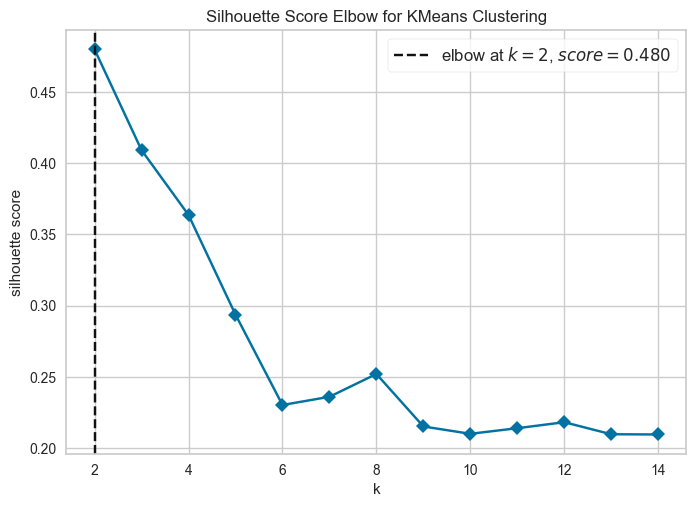

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [4]:
model = KMeans(random_state=42)

visualizer = KElbowVisualizer(model, k=(2, 15), metric="silhouette", timings=False)
visualizer.fit(df)
visualizer.show()

Según nuestros datos lo óptimo son 2 clusters. El silhouette score tiene un valor de 0.48, por lo que es razonablemente bueno. Más cercano a 1 serían unos clusters más definidos.

Ejecutaremos ahora el algoritmo K-means con 2 clusters

In [5]:
modelo_kmeans = KMeans(n_clusters=2)

km_fit = modelo_kmeans.fit(df)
labels = km_fit.labels_

Obtenemos las métricas

In [6]:
silhouette = silhouette_score(df, labels)
davies_bouldin = davies_bouldin_score(df, labels)

unique, counts = np.unique(labels, return_counts=True)
cardinalidad = dict(zip(unique, counts))

df_metrics = pd.DataFrame({
                    "silhouette_score": silhouette,
                    "davies_bouldin_index": davies_bouldin,
                    "cardinalidad": cardinalidad
                    })

df_metrics

,silhouette_score,davies_bouldin_index,cardinalidad
0,0.479972,0.881634,265
1,0.479972,0.881634,235


Ahora veamos las características de cada cluster para ver cómo lo podemos interpretar

In [7]:
df_kmeans = df.copy()

df_kmeans['cluster'] = km_fit.labels_

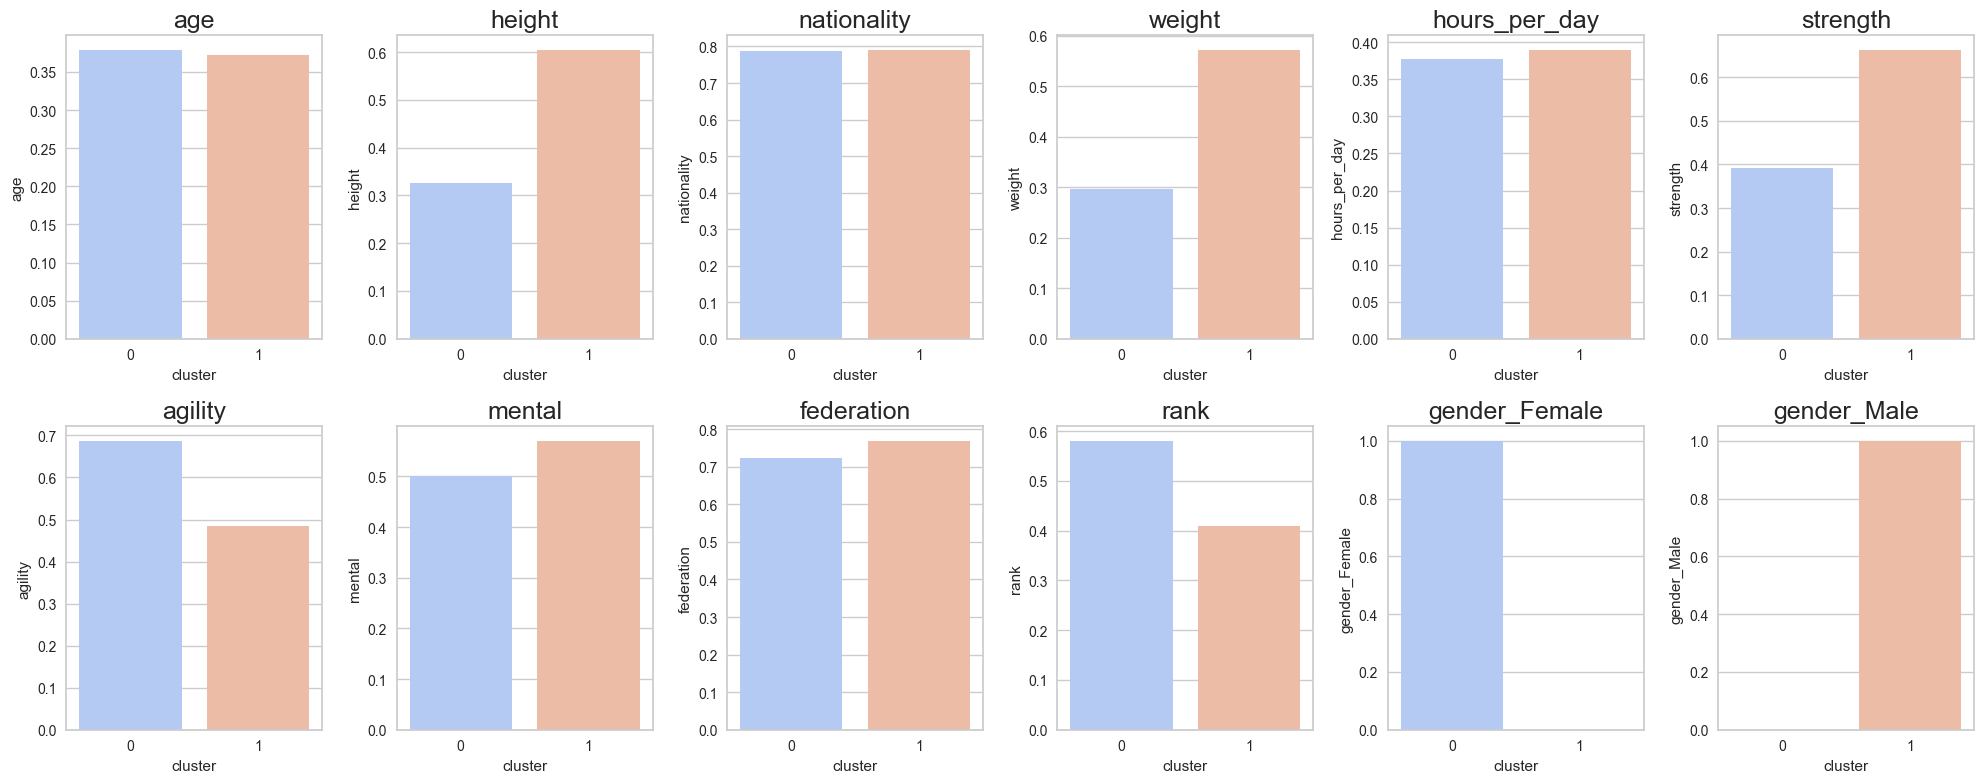

In [8]:
columnas = df_kmeans.drop(columns='cluster').columns.to_list()

fig, axes = plt.subplots(nrows=2, ncols=math.ceil(len(columnas)/2), figsize=(20, 8))

axes = axes.flat

for i, col in enumerate(columnas):

    df_group = df_kmeans.groupby('cluster')[col].mean().reset_index()

    sns.barplot(x='cluster', y=col, data=df_group, ax=axes[i], palette='coolwarm')
    axes[i].set_title(col, fontsize=18)

if len(columnas) % 2 != 0:
    fig.delaxes(axes[-1])

plt.tight_layout()

Vemos claramente que se han clasificado según el género

Hagamos un radar plot

In [9]:
columns = df.select_dtypes(include=np.number).columns.to_list()

columns

['age',
 'height',
 'nationality',
 'weight',
 'hours_per_day',
 'strength',
 'agility',
 'mental',
 'federation',
 'rank',
 'gender_Female',
 'gender_Male']

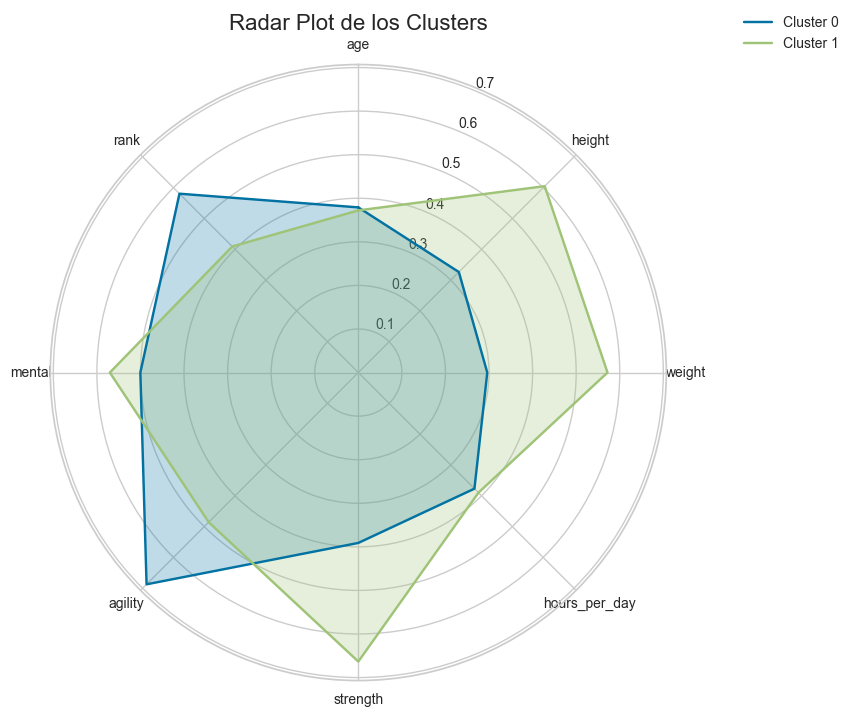

In [10]:
# Variables que deseas incluir en el radar plot
variables = ['age',
            'height',
            'weight',
            'hours_per_day',
            'strength',
            'agility',
            'mental',
            'rank']

# Agrupar por cluster y calcular la media
cluster_means = df_kmeans.groupby('cluster')[variables].mean()

# Repetir la primera columna al final para cerrar el radar
cluster_means = pd.concat([cluster_means, cluster_means.iloc[:, 0:1]], axis=1)

# Crear los ángulos para el radar plot
num_vars = len(variables)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # Cerrar el gráfico

# Crear el radar plot
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# Dibujar un gráfico para cada cluster
for i, row in cluster_means.iterrows():
    ax.plot(angles, row, label=f'Cluster {i}')
    ax.fill(angles, row, alpha=0.25)

# Configurar etiquetas de los ejes
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(variables)

# Añadir leyenda y título
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.title('Radar Plot de los Clusters', size=16)
plt.show()

Vemos en los resultados que efectivamente se corresponde con el análisis inicial que habíamos considerado

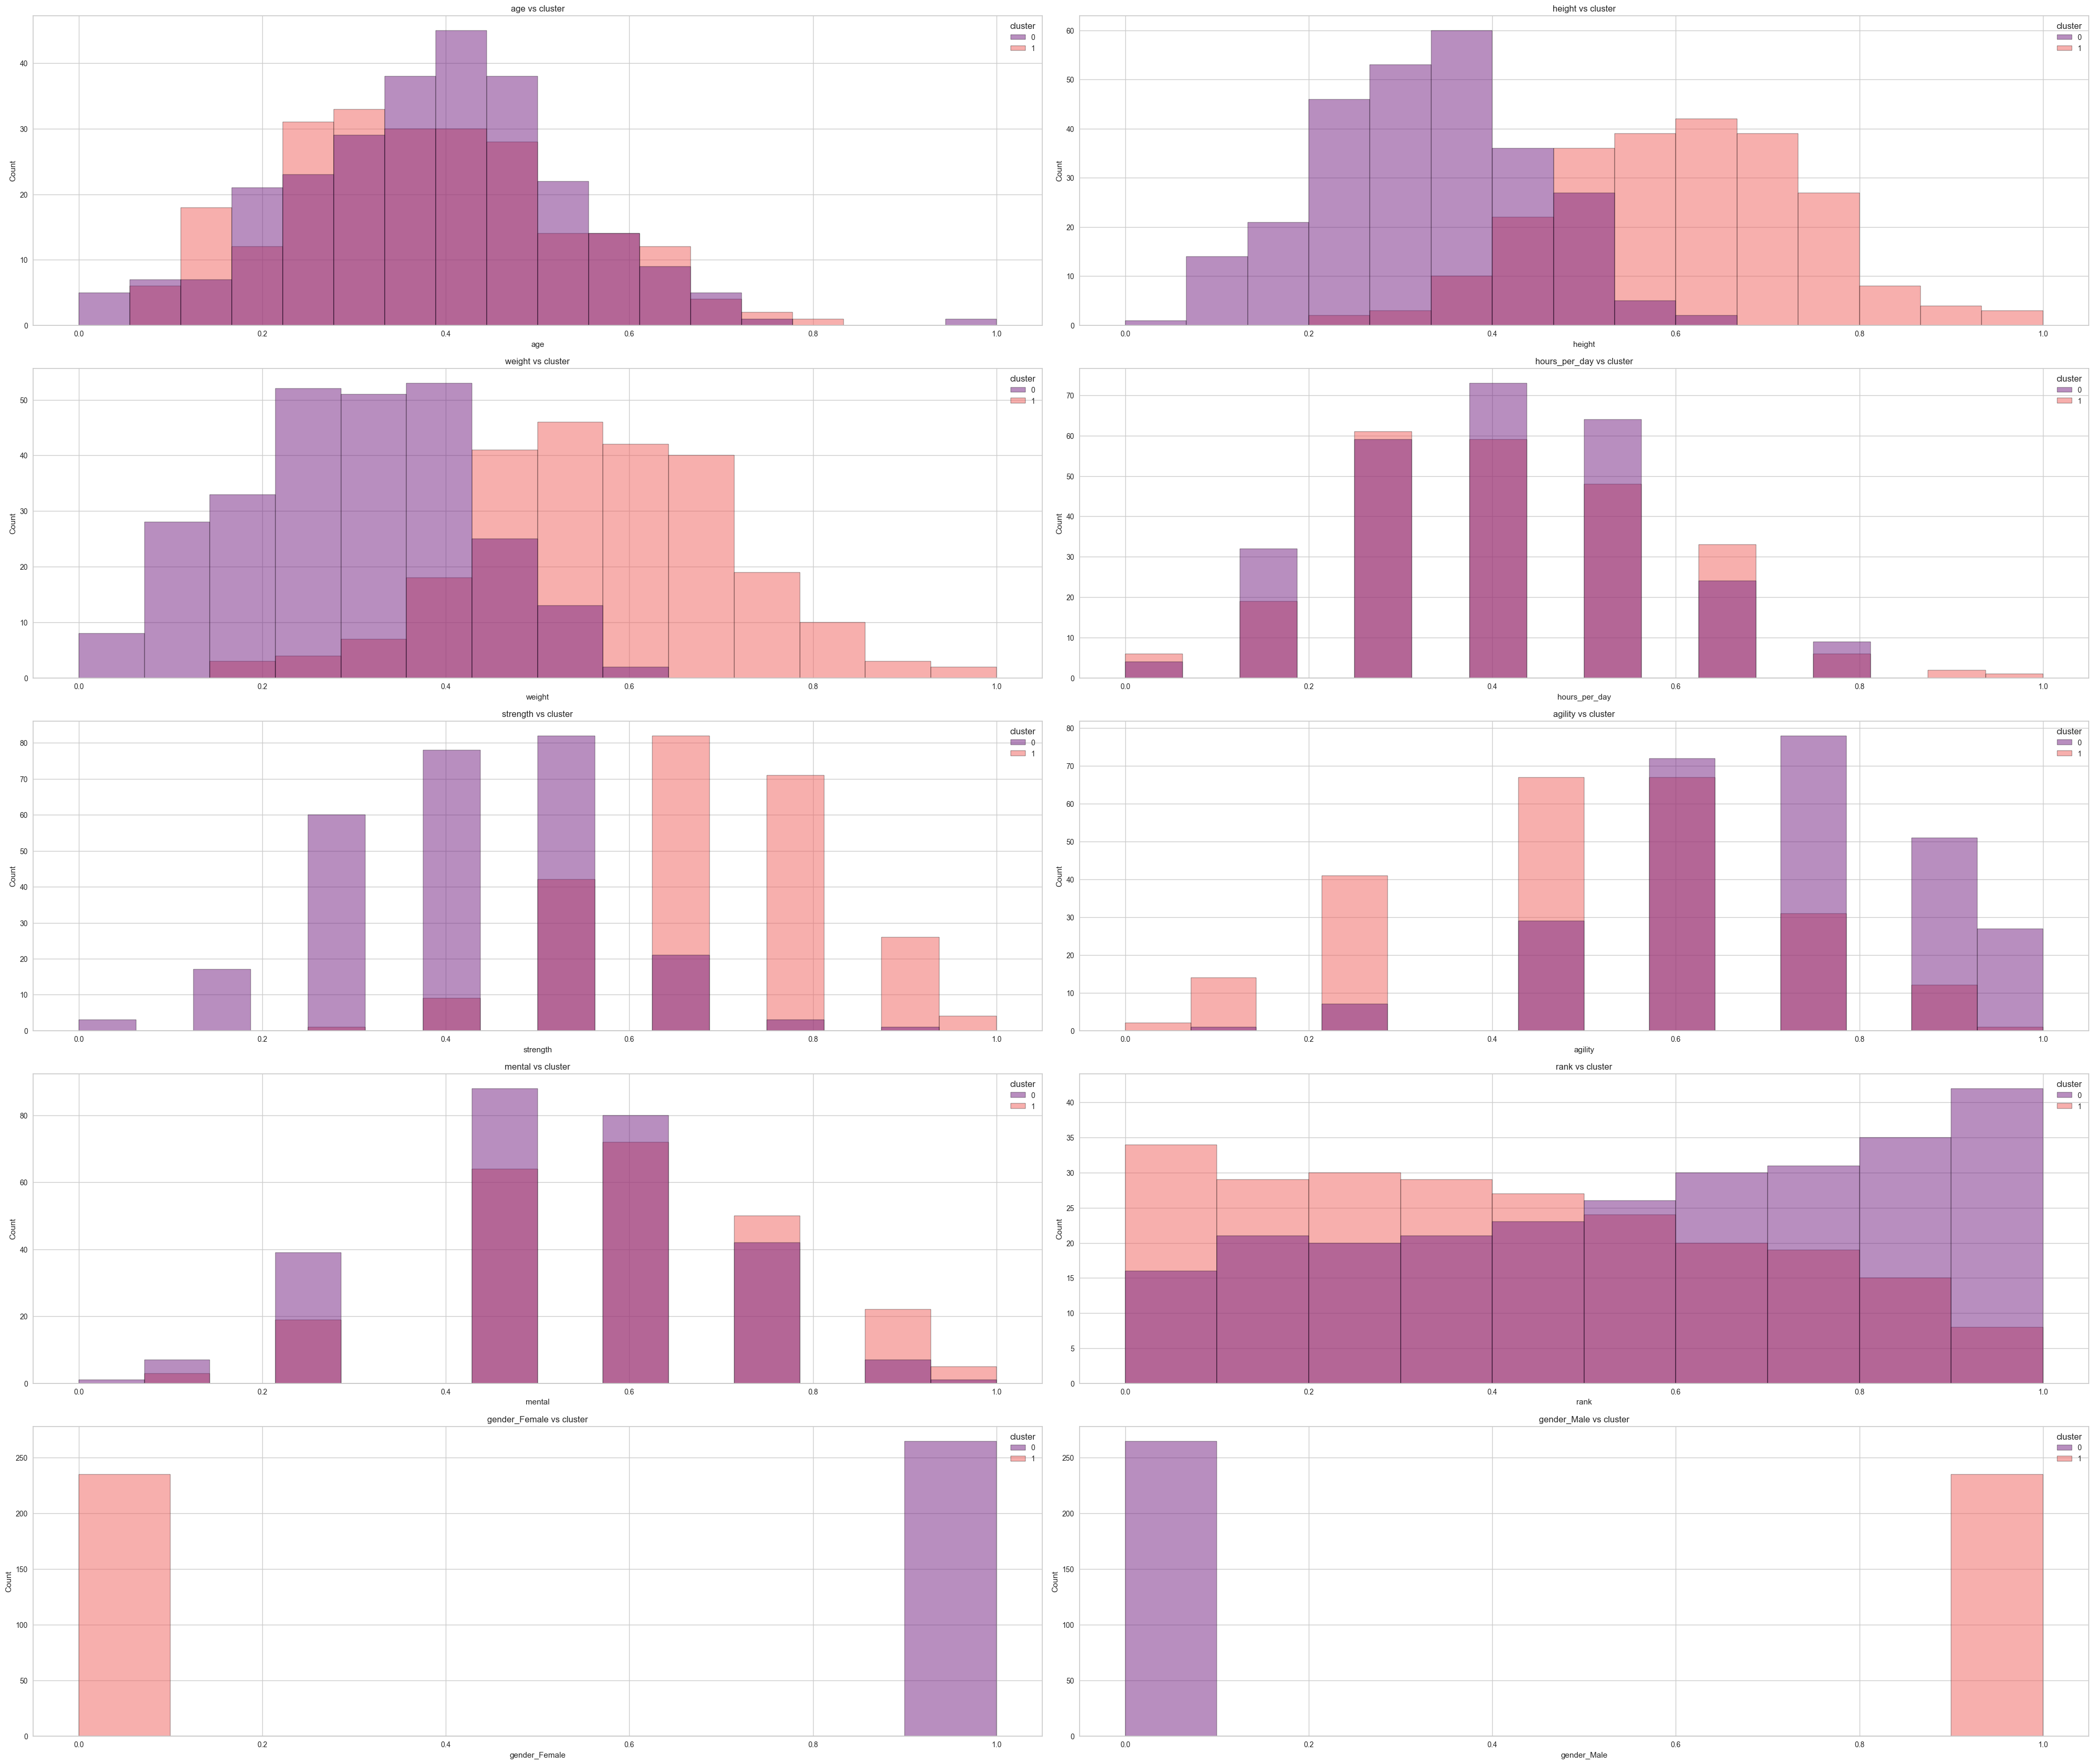

In [11]:
plot_relation_tv(df_kmeans.drop(columns=['nationality', 'federation']), 'cluster', size=(40, 40), n_cols = 2)

En estos gráficos se aprecia mejor la diferencia en distribución de `rank`, `strength`, `height` y `weight`, con ligeras diferencias en el resto de variables.

In [12]:
def plot_combined_target_distribution(df, target, feature, figsize=(10, 6)):
    fig, ax = plt.subplots(figsize=figsize)

    fig.suptitle(f"Proportion of '{target}' by '{feature}' distribution")
    
    # histograma total de conteo
    sns.histplot(data=df,
                x=feature,
                bins='auto',
                ax=ax)

    # plot second histogram for positive class probability
    ax2 = ax.twinx()

    sns.histplot(data=df,
             x=feature,
             hue=target,  
             stat="probability",  # normaliza para que enseñe la proporcion o 'probabilidad' de cada bin
             bins='auto', # igual que primer histograma
             multiple="fill",  # hacer que coja el máximo 1 en el tope superior del gráfico
             palette={1: "red", 0: "#FFFFFF"}, # rojo para positivo, blanco para negativo
             ax=ax2,
             alpha=0.3, # transparencia, importante
             edgecolor=None)


    ax2.set_ylim(0, 1)

    # quitar leyenda del ax2, hacer una a nivel de figura
    ax2.get_legend().remove()

    fig.legend([f"{feature.capitalize()} distribution", f"{target.capitalize()} proportion"], loc="upper right")

    plt.show()

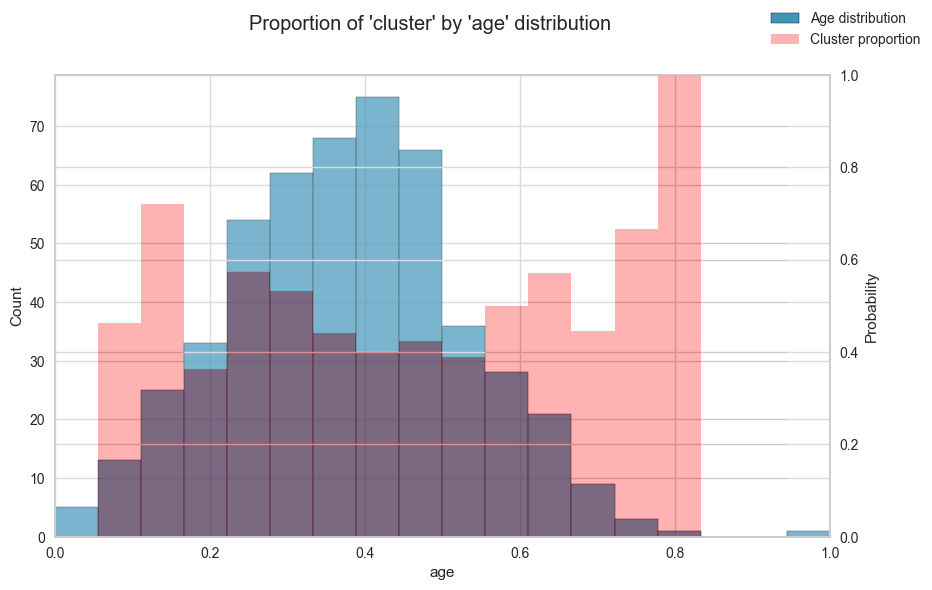

In [13]:
plot_combined_target_distribution(df_kmeans, 'cluster', 'age', figsize=(10, 6))